<a href="https://colab.research.google.com/github/VARUN-OFFICIAL-24/WeatherGuard/blob/main/Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Requirements**

In [ ]:
import os
import random
import requests
import schedule
import time
from typing import Dict, TypedDict, Union, List, Literal
import json
from datetime import datetime
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import smtplib
from email.mime.text import MIMEText
from dotenv import load_dotenv
from email.mime.multipart import MIMEMultipart


load_dotenv()

True

# Load Model

In [ ]:
llm = ChatOllama(model="llama3.2", verbose=True)

# Declare Types

In [ ]:
class WeatherState(TypedDict):
    city: str
    weather_data: Dict
    disaster_type: str
    severity: str
    response: str
    messages: List[Union[SystemMessage, HumanMessage, AIMessage]]
    alerts: List[str]
    human_approved: bool


**GET WEATHER DATA**

In [ ]:
def get_weather_data(state: WeatherState) -> Dict:
    """Fetch weather data from OpenWeatherMap API"""
    BASE_URL = "http://api.openweathermap.org/data/2.5/weather"
    API_KEY = os.getenv("OPENWEATHER_API_KEY")

    request_url = f"{BASE_URL}?appid={API_KEY}&q={state['city']}"
    try:
        response = requests.get(request_url)
        response.raise_for_status()

        data = response.json()
        weather_data = {
            "weather": data.get('weather', [{}])[0].get("description", "N/A"),
            "wind_speed": data.get("wind", {}).get("speed", "N/A"),
            "cloud_cover": data.get("clouds", {}).get("all", "N/A"),
            "sea_level": data.get("main", {}).get("sea_level", "N/A"),
            "temperature": round(data.get("main", {}).get("temp", 273.15) - 273.15, 1),
            "humidity": data.get("main", {}).get("humidity", "N/A"),
            "pressure": data.get("main", {}).get("pressure", "N/A")
        }

        return {
            **state,
            "weather_data": weather_data,
            "messages": state["messages"] + [SystemMessage(content=f"Weather data fetched successfully for {state['city']}")]
        }

    except Exception as e:
        error_data = {
            "weather": "N/A",
            "wind_speed": "N/A",
            "cloud_cover": "N/A",
            "sea_level": "N/A",
            "temperature": "N/A",
            "humidity": "N/A",
            "pressure": "N/A"
        }
        return {
            **state,
            "weather_data": error_data,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to fetch weather data for {state['city']}: {str(e)}")]
        }


**Analyze Disaster Type**

In [ ]:
def analyze_disaster_type(state: WeatherState) -> WeatherState:
    """Analyze weather data to identify potential disasters"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Based on the following weather conditions, identify if there's a potential weather disaster.\n"
        "Weather conditions:\n"
        "- Description: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°C\n"
        "- Humidity: {humidity}%\n"
        "- Pressure: {pressure} hPa\n"
        "Categorize into one of these types: Hurricane, Flood, Heatwave, Severe Storm, Winter Storm, or No Immediate Threat"
    )

    try:
        chain = prompt | llm
        disaster_type = chain.invoke(weather_data).content
        return {
            **state,
            "disaster_type": disaster_type,
            "messages": state["messages"] + [SystemMessage(content=f"Disaster type identified: {disaster_type}")]
        }
    except Exception as e:
        return {
            **state,
            "disaster_type": "Analysis Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to analyze disaster type: {str(e)}")]
        }

**Assess Severity**

In [ ]:
def assess_severity(state: WeatherState) -> WeatherState:
    """Assess the severity of the identified weather situation"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Given the weather conditions and identified disaster type '{disaster_type}', "
        "assess the severity level. Consider:\n"
        "- Weather: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°C\n"
        "Respond with either 'Critical', 'High', 'Medium', or 'Low'"
    )

    try:
        chain = prompt | llm
        severity = chain.invoke({
            **weather_data,
            "disaster_type": state["disaster_type"]
        }).content

        return {
            **state,
            "severity": severity,
            "messages": state["messages"] + [SystemMessage(content=f"Severity assessed as: {severity}")]
        }
    except Exception as e:
        return {
            **state,
            "severity": "Assessment Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to assess severity: {str(e)}")]
        }

**Emergency Response**

In [ ]:
def emergency_response(state: WeatherState) -> WeatherState:
    """Generate emergency response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create an emergency response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Include immediate actions needed."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Emergency response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate emergency response: {str(e)}")]
        }

**Civil Defense Response**

In [ ]:

def civil_defense_response(state: WeatherState) -> WeatherState:
    """Generate civil defense response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a civil defense response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on public safety measures."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Civil defense response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate civil defense response: {str(e)}")]
        }


**Public Work Response**

In [ ]:
def public_works_response(state: WeatherState) -> WeatherState:
    """Generate public works response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a public works response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on infrastructure protection."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Public works response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate public works response: {str(e)}")]
        }


# **DATA LOG**

In [ ]:
def data_logging(state: WeatherState) -> WeatherState:
    """Log weather data, disaster analysis, and response to a file."""
    log_data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "city": state["city"],
        "weather_data": state["weather_data"],
        "disaster_type": state["disaster_type"],
        "severity": state["severity"],
        "response": state["response"],
    }

    try:
        with open("disaster_log.txt", "a") as log_file:
            log_file.write(json.dumps(log_data) + "\n")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content="Data logged successfully")]
        }
    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to log data: {str(e)}")]
        }

# GET HUMAN VERIFICATION

In [ ]:
def get_human_verification(state: WeatherState) -> WeatherState:
    """Get human verification for low/medium severity alerts"""
    severity = state["severity"].strip().lower()

    if severity in ["low", "medium"]:
        print("\n" + "="*50)
        print(f"Low/Medium severity alert for {state['city']} requires human approval:")
        print(f"Disaster Type: {state['disaster_type']}")
        print(f"Current Weather: {state['weather_data']['weather']}")
        print(f"Temperature: {state['weather_data']['temperature']}°C")
        print(f"Wind Speed: {state['weather_data']['wind_speed']} m/s")
        print(f"Severity: {state['severity']}")
        print(f"Response Plan: {state['response']}")
        print("\nType 'y' to approve sending alert or 'n' to reject (waiting for input):")
        print("="*50)

        # Block and wait for input
        while True:
            try:
                user_input = input().lower().strip()
                if user_input in ['y', 'n']:
                    approved = user_input == 'y'
                    print(f"Human verification result: {'Approved' if approved else 'Rejected'}")
                    break
                else:
                    print("Please enter 'y' for yes or 'n' for no:")
            except Exception as e:
                print(f"Error reading input: {str(e)}")
                print("Please try again with 'y' or 'n':")

        return {
            **state,
            "human_approved": approved,
            "messages": state["messages"] + [
                SystemMessage(content=f"Human verification: {'Approved' if approved else 'Rejected'}")
            ]
        }
    else:
        # Auto-approve for high/critical severity
        return {
            **state,
            "human_approved": True,
            "messages": state["messages"] + [
                SystemMessage(content=f"Auto-approved {severity} severity alert")
            ]
        }

# **Email Requirements**

In [ ]:
sender_email = os.getenv("SENDER_EMAIL")
receiver_email = os.getenv("RECEIVER_EMAIL")
password = os.getenv("EMAIL_PASSWORD")

In [ ]:
sender_email

'anubis.ai.developer@gmail.com'

# **Email Alert**

In [ ]:
def send_email_alert(state: WeatherState) -> WeatherState:
    import os
    from dotenv import load_dotenv
    load_dotenv()
    """Send weather alert email"""
    sender_email = os.getenv("SENDER_EMAIL")
    receiver_email = os.getenv("RECEIVER_EMAIL")
    password = os.getenv("EMAIL_PASSWORD")

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = f"Weather Alert: {state['severity']} severity weather event in {state['city']}"

    body = format_weather_email(state)
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        text = msg.as_string()
        server.sendmail(sender_email, receiver_email, text)
        server.quit()

        # Add confirmation message
        severity = state["severity"].strip().lower()
        if severity in ["low", "medium"]:
            print(f"\nVerification was approved by human, Email sent to {receiver_email} successfully")
        else:
            print("\nEmail sent successfully for high severity alert")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Successfully sent weather alert email for {state['city']}")],
            "alerts": state["alerts"] + [f"Email alert sent: {datetime.now()}"]
        }

    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to send email alert: {str(e)}")]
        }

**No approval Handling**

In [ ]:
def handle_no_approval(state: WeatherState) -> WeatherState:
    """Handle cases where human verification was rejected"""
    print("\nVerification was not approved by human, Email not sent")

    message = (
        f"Alert not sent for {state['city']} - "
        f"Weather severity level '{state['severity']}' was deemed non-critical "
        f"by human operator and verification was rejected."
    )
    return {
        **state,
        "messages": state["messages"] + [SystemMessage(content=message)]
    }


**Route Response**

In [ ]:

def route_response(state: WeatherState) -> Literal["emergency_response", "send_email_alert", "civil_defense_response", "public_works_response"]:
    """Route to appropriate department based on disaster type and severity"""
    disaster = state["disaster_type"].strip().lower()
    severity = state["severity"].strip().lower()

    if severity in ["critical", "high"]:
        return "emergency_response"
        "send_email_alert"
    elif "flood" in disaster or "storm" in disaster:
        return "public_works_response"
    else:
        return "civil_defense_response"

In [ ]:

def verify_approval_router(state: WeatherState) -> Literal["send_email_alert", "handle_no_approval"]:
    """Route based on human approval decision"""
    return "send_email_alert" if state['human_approved'] else "handle_no_approval"

# **Email Format**

In [ ]:

def format_weather_email(state: WeatherState) -> str:
    """Format weather data and severity assessment into an email message"""
    weather_data = state["weather_data"]

    email_content = f"""
Weather Alert for {state['city']}

Disaster Type: {state['disaster_type']}
Severity Level: {state['severity']}

Current Weather Conditions:
- Weather Description: {weather_data['weather']}
- Temperature: {weather_data['temperature']}C
- Wind Speed: {weather_data['wind_speed']} m/s
- Humidity: {weather_data['humidity']}%
- Pressure: {weather_data['pressure']} hPa
- Cloud Cover: {weather_data['cloud_cover']}%

Response Plan:
{state['response']}

This is an automated weather alert generated at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    if state['severity'].lower() in ['low', 'medium']:
        email_content += "\nNote: This low/medium severity alert has been verified by a human operator."

    return email_content

# *Work Flow*

In [ ]:
# Create the workflow
workflow = StateGraph(WeatherState)

# Add nodes
workflow.add_node("get_weather", get_weather_data)
workflow.add_node("analyze_disaster", analyze_disaster_type)
workflow.add_node("assess_severity", assess_severity)
workflow.add_node("data_logging", data_logging)
workflow.add_node("emergency_response", emergency_response)
workflow.add_node("civil_defense_response", civil_defense_response)
workflow.add_node("public_works_response", public_works_response)
workflow.add_node("get_human_verification", get_human_verification)
workflow.add_node("send_email_alert", send_email_alert)
workflow.add_node("handle_no_approval", handle_no_approval)

# Add edges
workflow.add_edge("get_weather","analyze_disaster" )
workflow.add_edge("analyze_disaster", "assess_severity")
workflow.add_edge("assess_severity", "data_logging")
workflow.add_conditional_edges("data_logging", route_response)
workflow.add_edge("civil_defense_response", "get_human_verification")
workflow.add_edge("public_works_response", "get_human_verification")
workflow.add_conditional_edges("get_human_verification", verify_approval_router)
workflow.add_edge("emergency_response", "send_email_alert")
workflow.add_edge("send_email_alert", END)
workflow.add_edge("handle_no_approval", END)

workflow.set_entry_point("get_weather")

In [ ]:
# Compile the workflow
app = workflow.compile()

# **Initialize the System**

In [ ]:
def run_weather_emergency_system(city: str):
    """Initialize and run the weather emergency system for a given city"""
    initial_state = {
        "city": city,
        "weather_data": {},
        "disaster_type": "",
        "severity": "",
        "response": "",
        "messages": [],
        "alerts": [],
        "social_media_reports": [],
        "human_approved": False
    }

    try:
        result = app.invoke(initial_state)
        print(f"Completed weather check for {city}")
        return result
    except Exception as e:
        print(f"Error running weather emergency system: {str(e)}")

**MAIN**

In [ ]:
def main():
    """Main function to run the weather emergency system"""
    # Set up environment variables


    def scheduled_check():
        """Function to perform scheduled checks for multiple cities"""
        cities = input("Enter the cities you want to check : ").split()# Add more cities as needed
        print(f"\nStarting scheduled check at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

        for city in cities:
            try:
                print(f"\nChecking weather conditions for {city}...")
                run_weather_emergency_system(city)
                time.sleep(2)  # Brief pause between cities
            except Exception as e:
                print(f"Error checking {city}: {str(e)}")

    # Schedule checks every hour
    schedule.every(1).minute.do(scheduled_check)
    print("Weather Emergency Response System started.")
    print("Monitoring scheduled for every minute.")

    while True:
        try:
            schedule.run_pending()
            time.sleep(1)
            print("\nShutting down Weather Emergency Response System...")
            break
        except Exception as e:
            print(f"Error in main loop: {str(e)}")
            time.sleep(1)

if __name__ == "__main__":
    main()


Weather Emergency Response System started.
Monitoring scheduled for every minute.

Shutting down Weather Emergency Response System...


# **Structure**

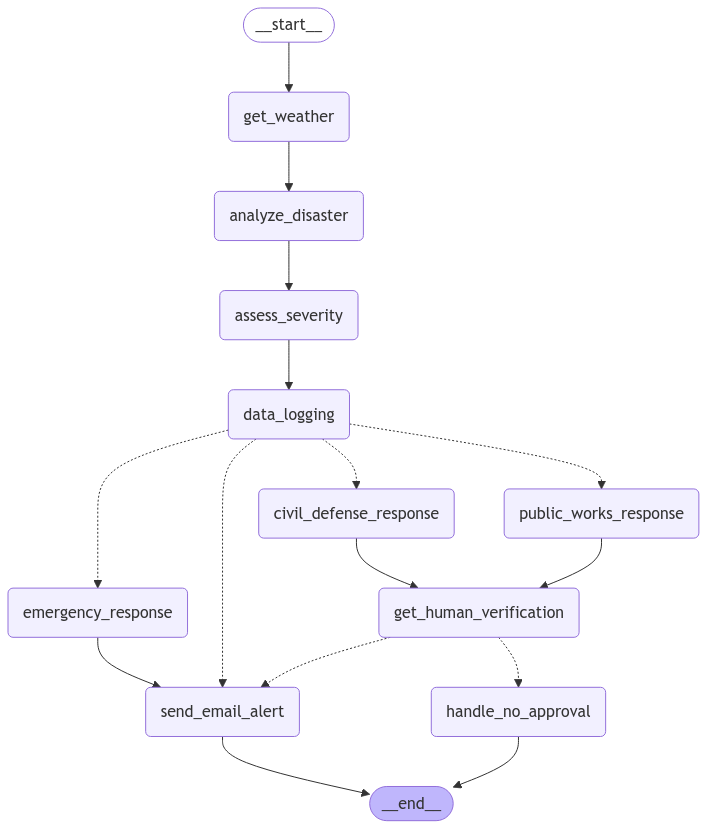

In [ ]:

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass




# **Full Code {Run it on local}**

In [ ]:
import os
import random
import requests
import schedule
import time
import json
import logging
from typing import Dict, TypedDict, Union, List, Literal
from datetime import datetime
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Set up logging
logging.basicConfig(filename='weather_em ergency.log', level=logging.DEBUG,
                    format='%(asctime)s:%(levelname)s:%(message)s')

llm = ChatOllama(model="llama3.2", verbose=True)

load_dotenv()

class WeatherState(TypedDict):
    city: str
    weather_data: Dict
    disaster_type: str
    severity: str
    response: str
    messages: List[Union[SystemMessage, HumanMessage, AIMessage]]
    alerts: List[str]
    human_approved: bool

def get_weather_data(state: WeatherState) -> Dict:
    """Fetch weather data from OpenWeatherMap API"""
    BASE_URL = "http://api.openweathermap.org/data/2.5/weather"
    API_KEY = os.getenv("OPENWEATHER_API_KEY")

    request_url = f"{BASE_URL}?appid={API_KEY}&q={state['city']}"
    try:
        response = requests.get(request_url)
        response.raise_for_status()

        data = response.json()
        weather_data = {
            "weather": data.get('weather', [{}])[0].get("description", "N/A"),
            "wind_speed": data.get("wind", {}).get("speed", "N/A"),
            "cloud_cover": data.get("clouds", {}).get("all", "N/A"),
            "sea_level": data.get("main", {}).get("sea_level", "N/A"),
            "temperature": round(data.get("main", {}).get("temp", 273.15) - 273.15, 1),
            "humidity": data.get("main", {}).get("humidity", "N/A"),
            "pressure": data.get("main", {}).get("pressure", "N/A")
        }

        logging.info(f"Weather Report for {state['city']}: {weather_data}")
        return {
            **state,
            "weather_data": weather_data,
            "messages": state["messages"] + [SystemMessage(content=f"Weather data fetched successfully for {state['city']}")]
        }

    except Exception as e:
        logging.error(f"Failed to fetch weather data for {state['city']}: {str(e)}")
        return {
            **state,
            "weather_data": {"weather": "N/A", "wind_speed": "N/A", "cloud_cover": "N/A", "sea_level": "N/A", "temperature": "N/A", "humidity": "N/A", "pressure": "N/A"},
            "messages": state["messages"] + [SystemMessage(content=f"Failed to fetch weather data for {state['city']}: {str(e)}")]
        }

def analyze_disaster_type(state: WeatherState) -> WeatherState:
    """Analyze weather data to identify potential disasters"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Based on the following weather conditions, identify if there's a potential weather disaster.\n"
        "Weather conditions:\n"
        "- Description: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°C\n"
        "- Humidity: {humidity}%\n"
        "- Pressure: {pressure} hPa\n"
        "Categorize into one of these types: Hurricane, Flood, Heatwave, Severe Storm, Winter Storm, or No Immediate Threat"
    )

    try:
        chain = prompt | llm
        disaster_type = chain.invoke(weather_data).content

        logging.info(f"Disaster Type Analysis for {state['city']}: {disaster_type}")
        return {
            **state,
            "disaster_type": disaster_type,
            "messages": state["messages"] + [SystemMessage(content=f"Disaster type identified: {disaster_type}")]
        }
    except Exception as e:
        logging.error(f"Failed to analyze disaster type for {state['city']}: {str(e)}")
        return {
            **state,
            "disaster_type": "Analysis Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to analyze disaster type: {str(e)}")]
        }

def assess_severity(state: WeatherState) -> WeatherState:
    """Assess the severity of the identified weather situation"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Given the weather conditions and identified disaster type '{disaster_type}', "
        "assess the severity level. Consider:\n"
        "- Weather: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°C\n"
        "Respond with either 'Critical', 'High', 'Medium', or 'Low'"
    )

    try:
        chain = prompt | llm
        severity = chain.invoke({
            **weather_data,
            "disaster_type": state["disaster_type"]
        }).content

        logging.info(f" Severity Assessment for {state['city']}: {severity}")
        return {
            **state,
            "severity": severity,
            "messages": state["messages"] + [SystemMessage(content=f"Severity assessed as: {severity}")]
        }

    except Exception as e:
        logging.error(f"Failed to assess severity for {state['city']}: {str(e)}")
        return {
            **state,
            "severity": "Assessment Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to assess severity: {str(e)}")]
        }

def emergency_response(state: WeatherState) -> WeatherState:
    """Generate emergency response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create an emergency response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Include immediate actions needed."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        logging.info(f"Emergency Response Plan for {state['city']}: {response}")
        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Emergency response plan generated")]
        }

    except Exception as e:
        logging.error(f"Failed to generate emergency response plan for {state['city']}: {str(e)}")
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate emergency response: {str(e)}")]
        }

def civil_defense_response(state: WeatherState) -> WeatherState:
    """Generate civil defense response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a civil defense response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on public safety measures."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        logging.info(f"Civil Defense Response Plan for {state['city']}: {response}")
        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Civil defense response plan generated")]
        }

    except Exception as e:
        logging.error(f"Failed to generate civil defense response plan for {state['city']}: {str(e)}")
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate civil defense response: {str(e)}")]
        }

def public_works_response(state: WeatherState) -> WeatherState:
    """Generate public works response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a public works response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on infrastructure protection."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        logging.info(f"Public Works Response Plan for {state['city']}: {response}")
        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Public works response plan generated")]
        }

    except Exception as e:
        logging.error(f"Failed to generate public works response plan for {state['city']}: {str(e)}")
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate public works response: {str(e)}")]
        }

def data_logging(state: WeatherState) -> WeatherState:
    """Log weather data, disaster analysis, and response to a file."""
    log_data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "city": state["city"],
        "weather_data": state["weather_data"],
        "disaster_type": state["disaster_type"],
        "severity": state["severity"],
        "response": state["response"],
    }

    try:
        with open("disaster_log.txt", "a") as log_file:
            log_file.write(json.dumps(log_data) + "\n")

        logging.info("Data logged successfully.")
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content="Data logged successfully")]
        }
    except Exception as e:
        logging.error(f"Failed to log data: {str(e)}")
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to log data: {str(e)}")]
        }

def get_human_verification(state: WeatherState) -> WeatherState:
    """Get human verification for low/medium severity alerts"""
    severity = state["severity"].strip().lower()

    if severity in ["low", "medium"]:
        logging.info(f"Low/Medium severity alert for {state['city']} requires human approval.")
        # Simulate human approval for testing purposes
        approved = True  # Change this to False to simulate rejection
        logging.info(f"Human verification result: {'Approved' if approved else 'Rejected'}")
        return {
            **state,
            "human_approved": approved,
            "messages": state["messages"] + [
                SystemMessage(content=f"Human verification: {'Approved' if approved else 'Rejected'}")
            ]
        }
    else:
        logging.info(f"Auto-approving {severity} severity alert for {state['city']}.")
        return {
            **state,
            "human_approved": True,
            "messages": state["messages"] + [
                SystemMessage(content=f"Auto-approved {severity} severity alert")
            ]
        }

def send_email_alert(state: WeatherState) -> WeatherState:
    """Send weather alert email"""
    load_dotenv()

    sender_email = os.getenv("SENDER_EMAIL")
    receiver_email = os.getenv("RECEIVER_EMAIL")
    password = os.getenv("EMAIL_PASSWORD")

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email

    # Check if a disaster type is identified
    if state['disaster_type'] and state['severity']:
        msg['Subject'] = f"Weather Alert: {state['severity']} severity weather event in {state['city']}"
    else:
        msg['Subject'] = f"Weather Report for {state['city']}"

    body = format_weather_email(state)
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()

        logging.info(f"Successfully sent email for {state['city']}.")
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Successfully sent email for {state['city']}")],
            "alerts": state["alerts"] + [f"Email alert sent: {datetime.now()}"]
        }

    except smtplib.SMTPAuthenticationError:
        logging.error("SMTP Authentication Error: Check your email and password.")
    except smtplib.SMTPConnectError:
        logging.error("SMTP Connect Error: Unable to connect to the SMTP server.")
    except Exception as e:
        logging.error(f"Failed to send email alert: {str(e)}")
    return {
        **state,
        "messages": state["messages"] + [SystemMessage(content=f"Failed to send email alert: {str(e)}")]
    }

def handle_no_approval(state: WeatherState) -> WeatherState:
    """Handle cases where human verification was rejected"""
    logging.info("Verification was not approved by human, Email not sent")
    message = (
        f"Alert not sent for {state['city']} - "
        f"Weather severity level '{state['severity']}' was deemed non-critical "
        f"by human operator and verification was rejected."
    )

    return {
        **state,
        "messages": state["messages"] + [SystemMessage(content=message)]
    }

def route_response(state: WeatherState) -> Literal[
    "emergency_response", "send_email_alert", "civil_defense_response", "public_works_response"]:
    """Route to appropriate department based on disaster type and severity"""
    disaster = state["disaster_type"].strip().lower()
    severity = state["severity"].strip().lower()

    logging.info(f"Routing decision based on disaster type: {disaster} and severity: {severity}")

    if severity in ["critical", "high"]:
        logging.info("Routing to 'emergency_response' due to high or critical severity.")
        return "emergency_response"
    elif "flood" in disaster or "storm" in disaster:
        logging.info("Routing to 'public_works_response' due to flood or storm disaster.")
        return "public_works_response"
    else:
        logging.info("Routing to 'civil_defense_response' for other disaster types.")
        return "civil_defense_response"

def verify_approval_router(state: WeatherState) -> Literal["send_email_alert", "handle_no_approval"]:
    """Route based on human approval decision"""
    if state['human_approved']:
        logging.info("Human approval granted, routing to 'send_email_alert'.")
        return "send_email_alert"
    else:
        logging.info("Human approval rejected, routing to 'handle_no_approval'.")
        return "handle_no_approval"

def format_weather_email(state: WeatherState) -> str:
    """Format weather data and severity assessment into an email message"""
    weather_data = state["weather_data"]

    # Start constructing the email content
    email_content = f"""
Weather Report for {state['city']}

Current Weather Conditions:
- Weather Description: {weather_data['weather']}
- Temperature: {weather_data['temperature']}°C
- Wind Speed: {weather_data['wind_speed']} m/s
- Humidity: {weather_data['humidity']}%
- Pressure: {weather_data['pressure']} hPa
- Cloud Cover: {weather_data['cloud_cover']}%

"""

    # Include disaster information if applicable
    if state['disaster_type'] and state['severity']:
        email_content += f"""
Disaster Type: {state['disaster_type']}
Severity Level: {state['severity']}

Response Plan:
{state['response']}
"""

    email_content += f"This is an automated weather report generated at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

    # Add extra note for low/medium severity
    if state['severity'].lower() in ['low', 'medium']:
        email_content += "\nNote: This low/medium severity alert has been verified by a human operator."

    logging.debug(f"Formatted email content:\n{email_content}")
    return email_content

# Create the workflow with WeatherState
workflow = StateGraph(WeatherState)

# Add nodes (each function is a node in the workflow)
workflow.add_node("get_weather", get_weather_data)
workflow.add_node("analyze_disaster", analyze_disaster_type)
workflow.add_node("assess_severity", assess_severity)
workflow.add_node("data_logging", data_logging)
workflow.add_node("emergency_response", emergency_response)
workflow.add_node("civil_defense_response", civil_defense_response)
workflow.add_node("public_works_response", public_works_response)
workflow.add_node("get_human_verification", get_human_verification)
workflow.add_node("send_email_alert", send_email_alert)
workflow.add_node("handle_no_approval", handle_no_approval)

# Add edges to define the order of execution between nodes
workflow.add_edge("get_weather", "analyze_disaster")
workflow.add_edge("analyze_disaster", "assess_severity")
workflow.add_edge("assess_severity", "data_logging")

# Conditional edges (decision points where routing is required)
workflow.add_conditional_edges("data_logging", route_response)
workflow.add_edge("civil_defense_response", "get_human_verification")
workflow.add_edge("public_works_response", "get_human_verification")
workflow.add_conditional_edges("get_human_verification", verify_approval_router)

# Proceed with sending email alerts or handling rejections
workflow.add_edge("emergency_response", "send_email_alert")
workflow.add_edge("send_email_alert", END)
workflow.add_edge("handle_no_approval", END)

# Set the entry point (start of the workflow)
workflow.set_entry_point("get_weather")

app = workflow.compile()

def run_weather_emergency_system(city: str):
    """Initialize and run the weather emergency system for a given city"""
    initial_state = {
        "city": city,
        "weather_data": {},
        "disaster_type": "",
        "severity": "",
        "response": "",
        "messages": [],
        "alerts": [],
        "social_media_reports": [],
        "human_approved": False
    }

    try:
        result = app.invoke(initial_state)
        logging.info(f"Completed weather check for {city}")
        return result
    except Exception as e:
        logging.error(f"Error running weather emergency system: {str(e)}")
        return None

def main():
    """Main function to run the weather emergency system"""
    os.environ["SENDER_EMAIL"] = "anubis.ai.developer@gmail.com"  # Replace with your email
    os.environ["RECEIVER_EMAIL"] = "bigilsuri@gmail.com"  # Replace with recipient email
    os.environ["EMAIL_PASSWORD"] = "xzoa afnx wofr tttg"

    def scheduled_check():
        """Function to perform scheduled checks for multiple cities"""
        cities = input("Enter the cities you want to check: ").split()
        logging.info(f"Starting scheduled check at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

        for city in cities:
            try:
                logging.info(f"Checking weather conditions for {city}...")
                run_weather_emergency_system(city)
                time.sleep(2)  # Brief pause between cities
            except Exception as e:
                logging.error(f"Error checking {city}: {str(e)}")

    # Schedule checks every hour
    schedule.every(1).minute.do(scheduled_check)
    logging.info("Weather Emergency Response System started.")
    logging.info("Monitoring scheduled for every minute.")

    while True:
        try:
            schedule.run_pending()
            time.sleep(1)
        except Exception as e:
            logging.error(f"Error in main loop: {str(e)}")
            time.sleep(1)

if __name__ == "__main__":
    main()